In [1]:
import os
import astropy.table

In [2]:
CATSIM_CATALOG_PATH = "/sps/lsst/users/bbiswas/OneDegSq.fits"

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

In [3]:
catalog

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995
2208734677,0.42108619213,-7.25999998394e-05,1.16251754761,0.0,1.74001598433e-18,0.0,0.0,0.312852591276,0.0,0.180962398648,0.0,217.517120361,27.3159255981,27.4167633057,27.051820755,26.6737632751,25.9380722046,25.6458129883
2212241881,0.423181056976,-0.00218109996058,1.35479903221,0.0,1.11031595423e-18,0.0,0.0,0.414316505194,0.0,0.205554202199,0.0,226.523849487,27.3325939178,27.4470024109,27.3282527924,27.0680370331,26.7419490814,26.1817016602
2204477290,0.422583341599,-0.000604000000749,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289
2201104165,0.422105312347,-0.00160690001212,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569
2211831084,0.422278761862,-0.00242089992389,1.52316868305,0.0,1.06012697736e-18,0.0,0.0,0.216705903411,0.0,0.123286098242,0.0,13.71824646,27.2072696686,27.268491745,27.2910671234,27.0573310852,26.8970832825,26.4211711884
2213920571,0.428705215453,-0.00933680031449,1.01047706604,0.0,2.24895700248e-19,0.0,0.0,0.229738906026,0.0,0.175429001451,0.0,281.466491699,26.6581230164,26.9268531799,27.170211792,27.3262882233,27.3432483673,27.5143566132


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

In [5]:
from galcheat.utilities import mag2counts, mean_sky_level
import numpy as np

(0.0, 2.0)

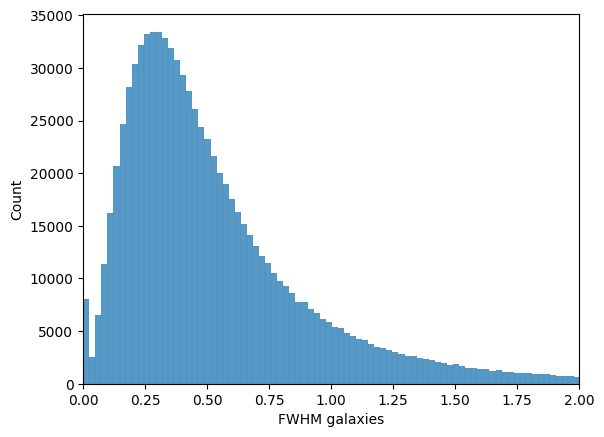

In [6]:
ax = sns.histplot(2* np.sqrt(catalog["a_d"]*catalog["b_d"]), bins=2000)
ax.set_xlabel("FWHM galaxies")
ax.set_xlim((0,2))

# Compute SNR

In [7]:
snr = []

# For calculation of source counts (C) and mean_sky_level (B) refer to https://github.com/aboucaud/galcheat/blob/main/galcheat/utilities.py
# For Computaion of SNR, refer to: https://smtn-002.lsst.io/

# background noise
B = mean_sky_level("LSST", "r").to_value("electron")

# Assume gain = 1 
g=1

# compute sigma_instr https://smtn-002.lsst.io/
dark_current = 0.2
exp_time = 15 # 2 * 15 sec exposures
num_exp = 184 * 2 # 184 visits from: https://arxiv.org/pdf/0805.2366.pdf
read_noise = 8.8

sig_instr = np.sqrt((read_noise**2 + dark_current*exp_time) * num_exp)
# But BTK does not add instr noise (https://github.com/LSSTDESC/BlendingToolKit/blob/main/btk/draw_blends.py lines: 418-432)
sig_instr = 0 # ok to set it to 0 ??

@jit 
def computeFWHM(hlr_a, hlr_b):
    return 2*np.sqrt(hlr_a*hlr_b) # fwhm = 2*hlr from: https://www.researchgate.net/publication/1778778_Accurate_photometry_of_extended_spherically_symmetric_sources/figures?lo=1

@jit
def compute_snr(C, B, FWHM_gal, FWHM_PSF=.83, sig_insrt=sig_instr):

    # convolve with PSF with FWHM of galaxy
    FWHM = np.sqrt(FWHM_gal**2 + .83**2) # convolution of 2 PSF

    # Source footprint https://smtn-002.lsst.io/
    n_eff = 2.266*((FWHM/.2)**2) 

    # compute_snr
    snr = C / np.sqrt(C + ( B / g + sig_instr**2) * n_eff) # from : https://smtn-002.lsst.io/
    return snr


for row in catalog:
    # Source counts 
    C = mag2counts(row['r_ab'], "LSST", "r").to_value("electron") # is this correct?
    
    # FWHM of galaxy
    FWHM_row_d = computeFWHM(row["a_d"], row["b_d"])
    FWHM_row_b = computeFWHM(row["a_b"], row["b_b"])
    FWHM_gal = FWHM_row_d if FWHM_row_d > FWHM_row_b else FWHM_row_b

    current_snr = compute_snr(C=C, B=B, FWHM_gal=FWHM_gal)

    snr.append(current_snr)

In [8]:
snr = np.array(snr)

### Plot distribution of SNR

Text(0.5, 0, 'SNR')

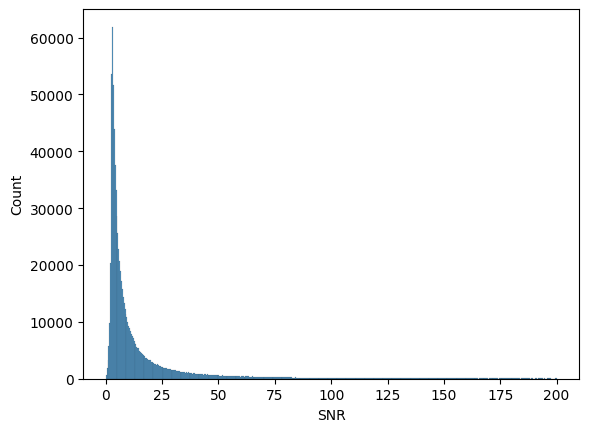

In [9]:
sns.histplot(snr[snr<=200], bins=500);
plt.xlabel("SNR")

Text(0.5, 0, 'SNR')

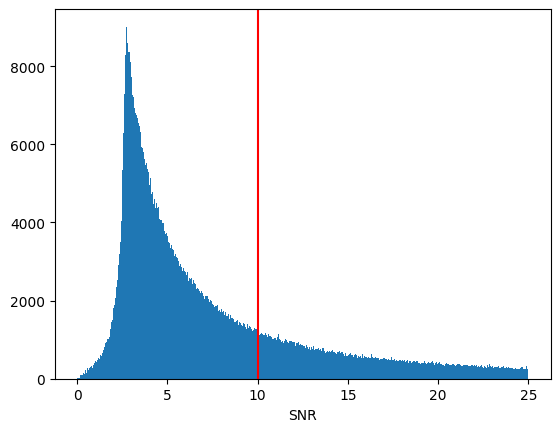

In [10]:
plt.hist(snr[snr<=25], bins=500);
plt.axvline(10, color='r')
plt.xlabel("SNR")

Text(0.5, 0, 'SNR')

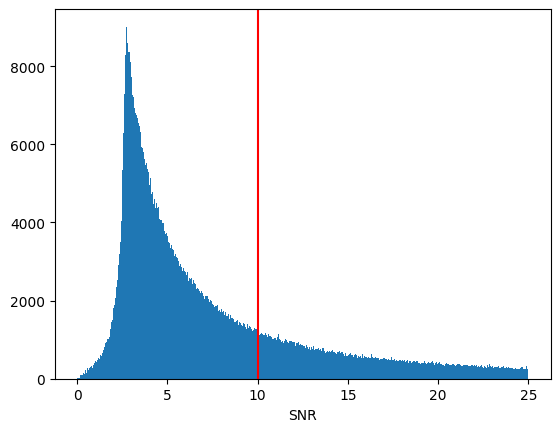

In [11]:
plt.hist(snr[snr<=25], bins=500);
plt.axvline(10, color='r')
plt.xlabel("SNR")

In [12]:
import seaborn as sns

Text(0, 0.5, 'mag')

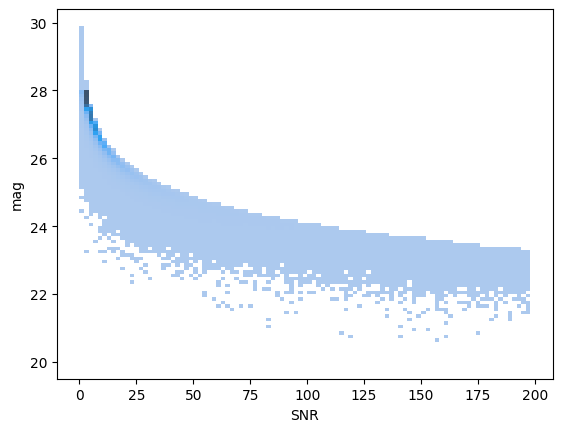

In [13]:
x_bins = np.arange(0,200, 200/100.0)
y_bins = np.arange(20, 30, 10/100.0)

ax = sns.histplot(x=snr, y=catalog["r_ab"], bins=[x_bins, y_bins], kde=True)

ax.set_xlabel("SNR")
ax.set_ylabel("mag")

In [14]:
catalog["r_band_snr"] = snr

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

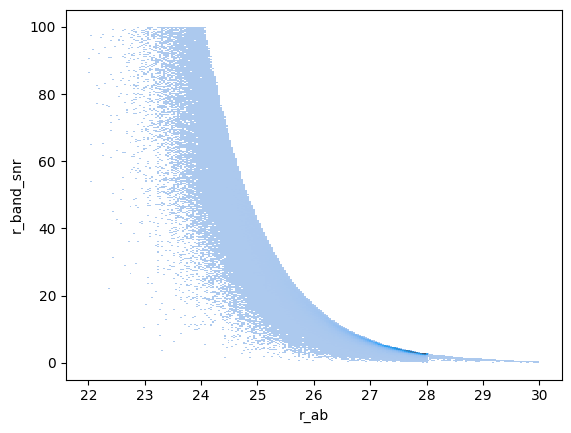

In [15]:
sns.histplot(data=catalog.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(22, 30), (0,100)])

In [16]:
frac = np.sum(snr<5)/len(snr)*100
print(f"Percentage below snr 5 : {frac}")

Percentage below snr 5 : 39.35354839010276


### Isolate snr 10 datalog 

In [17]:
snr_10_cat = catalog[snr>=10]

(10, 1000)

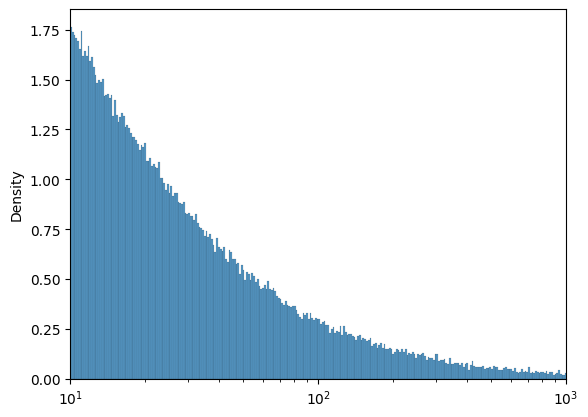

In [18]:
ax = sns.histplot(snr_10_cat["r_band_snr"], log_scale=True, stat="density", bins=500)
ax.set_xlim(10,1000)

<AxesSubplot:ylabel='Density'>

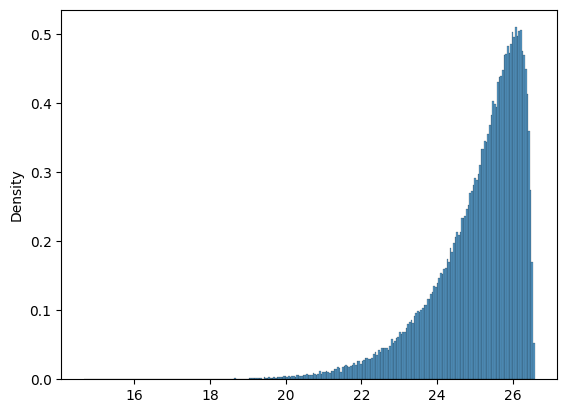

In [19]:
sns.histplot(snr_10_cat["r_ab"], stat="density")

In [20]:
catalog.colnames

['galtileid',
 'ra',
 'dec',
 'redshift',
 'fluxnorm_bulge',
 'fluxnorm_disk',
 'fluxnorm_agn',
 'a_b',
 'a_d',
 'b_b',
 'b_d',
 'pa_bulge',
 'pa_disk',
 'u_ab',
 'g_ab',
 'r_ab',
 'i_ab',
 'z_ab',
 'y_ab',
 'r_band_snr']

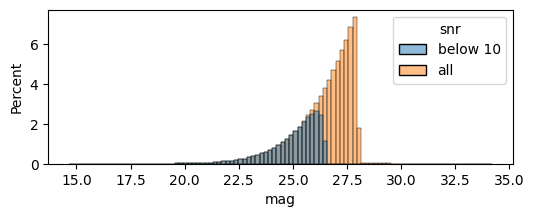

In [21]:
import pandas as pd
sns_mag_df = {}

sns_mag_df["mag"] = list(snr_10_cat["r_ab"])
sns_mag_df["snr"] = ["below 10"]*len(snr_10_cat)

sns_mag_df["mag"].extend(list(catalog["r_ab"]))
sns_mag_df["snr"].extend(["all"]*len(catalog))

sns_mag_df = pd.DataFrame(sns_mag_df)

plt.figure(figsize=(6,2))

bins = sns.histplot(data=sns_mag_df, x="mag", hue="snr", bins=100, alpha=.5, stat='percent')
#sns.(catalog["i_ab"], bins=bins[1], alpha=.5)

In [22]:
len(snr_10_cat)

313307

In [23]:
snr_10_cat.columns

<TableColumns names=('galtileid','ra','dec','redshift','fluxnorm_bulge','fluxnorm_disk','fluxnorm_agn','a_b','a_d','b_b','b_d','pa_bulge','pa_disk','u_ab','g_ab','r_ab','i_ab','z_ab','y_ab','r_band_snr')>

<AxesSubplot:ylabel='Count'>

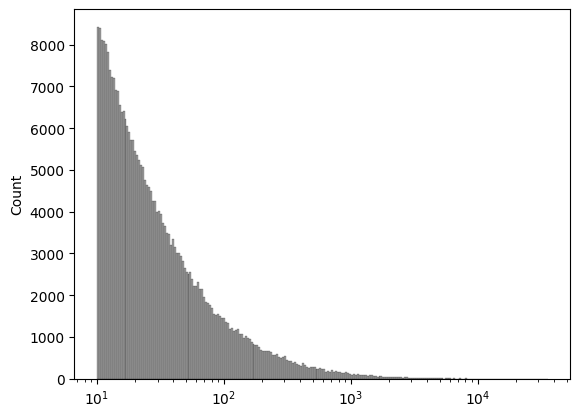

In [24]:
sns.histplot(snr_10_cat["r_band_snr"], kde=False, log_scale=True, color="0.5")

In [25]:
#snr_10_cat.write("/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits", overwrite=True)

In [26]:
CATSIM_CATALOG_PATH = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
test_catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

In [27]:
len(test_catalog)

313149

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

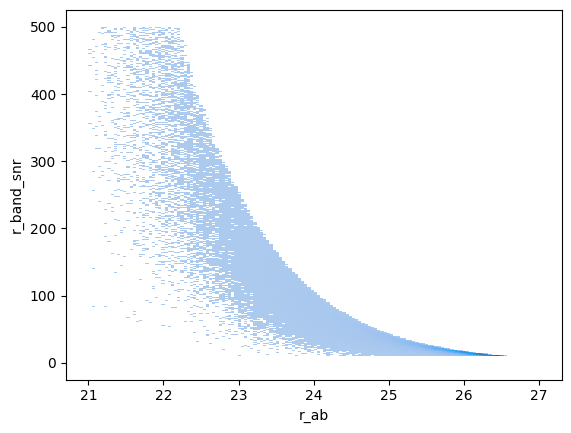

In [28]:
sns.histplot(data=snr_10_cat.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(21, 27), (0,500)])

In [29]:
snr_10_cat['log_snr'] = np.log10(snr_10_cat['r_band_snr'])

<AxesSubplot:ylabel='Count'>

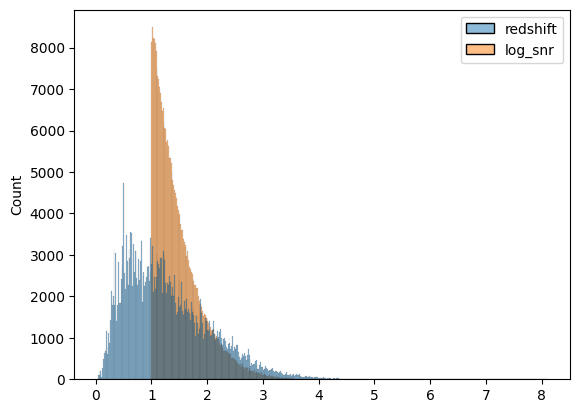

In [30]:
sns.histplot(snr_10_cat['redshift', 'log_snr'].to_pandas())

<AxesSubplot:xlabel='redshift', ylabel='log_snr'>

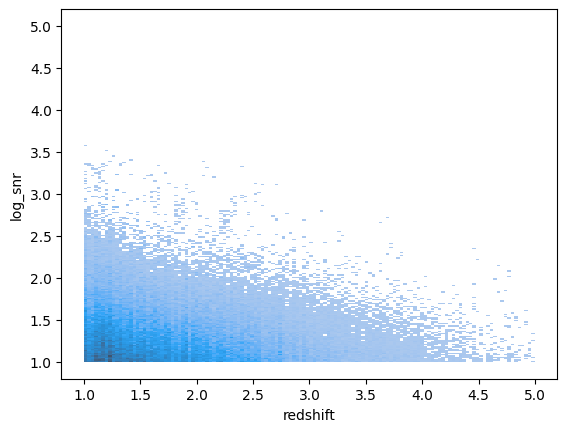

In [31]:
sns.histplot(data=snr_10_cat.to_pandas(), x="redshift", y="log_snr", binrange=[(1, 5), (1,5)])

In [32]:
snr_10_cat

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab,r_band_snr,log_snr
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2200871446,0.418319702147,-0.000148399994941,0.496377289295,0.0,1.4144730572e-17,0.0,0.0,0.278649687767,0.0,0.221303001046,0.0,307.344329834,25.9418621063,25.129743576,23.9588813782,23.3607368469,23.0723800659,22.9095973969,94.69486939945658,1.9763264494165167
2205921112,0.420028448104,-0.00100259995088,1.89508104324,0.0,1.91501907101e-18,0.0,0.0,0.358063697815,0.0,0.313674807549,0.0,137.791702271,25.848903656,25.867565155,25.9179477692,25.9851398468,25.8779563904,25.7642536163,14.353542781685498,1.1569591080831743
2205010878,0.423432350157,-0.00312969996594,1.93795013428,0.0,2.15612608955e-18,0.0,0.0,0.444279909134,0.0,0.424689114094,0.0,233.972427368,25.5657653809,25.5659580231,25.6165962219,25.6957893372,25.6281528473,25.5399188995,16.820384815071808,1.2258359273210202
2204477290,0.422583341599,-0.000604000000749,1.33114361763,0.0,5.75775484903e-18,0.0,0.0,0.351797997952,0.0,0.126827403903,0.0,53.955165863,25.6527175903,25.7753200531,25.4755821228,25.2793464661,24.9572029114,24.4631252289,24.6524701914457,1.3918604423461174
2201104165,0.422105312347,-0.00160690001212,0.812159895897,6.57883086866e-18,2.26453001134e-17,0.0,0.22702370584,0.191140606999,0.20540009439,0.0433686003089,24.3779182434,24.3779182434,25.9493045807,25.4186573029,24.5099773407,23.527223587,23.0481529236,22.813867569,59.30719573903821,1.7731073894885048
2205029524,0.426759123802,-0.00588729977608,2.62337517738,1.76236800714e-19,4.00829308249e-18,0.0,0.310758501291,0.353145509958,0.297534286976,0.163112699986,192.710525513,192.710525513,26.6237487793,25.6349658966,25.4367675781,25.620885849,25.5596847534,25.3557510376,23.142746023796025,1.3644148892840746
2205796354,0.428714990615,-0.00757079990581,0.748833298683,0.0,1.2929780096e-18,0.0,0.0,0.506412088871,0.0,0.406899303198,0.0,358.394989014,25.8366546631,25.9559650421,26.0390605927,25.79139328,25.7958583832,25.7776908875,11.143876675030908,1.0470362972735958
2205780198,0.425186038016,-0.00684770010412,2.73673796654,2.36539905575e-20,1.71083698143e-18,0.0,0.0929801985621,0.651051819324,0.0813373029232,0.228484198451,349.739440918,349.739440918,26.6940460205,25.7389945984,25.4774112701,25.7938842773,25.8609008789,25.6114196777,20.260898036081098,1.3066586909487963
2204160733,0.426273226737,-0.00803610030562,0.883550703526,0.0,2.79284505734e-18,0.0,0.0,0.282541513443,0.0,0.142981693149,0.0,66.6810913086,26.5272636414,26.4191303253,26.1512069702,25.3752822876,25.1441688538,25.1374740601,13.391885861096558,1.1268417391776213
